In [1]:
%matplotlib inline

import io
import os.path
import requests
import csv
import math
import json
import requests
import time
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from requests.auth import HTTPBasicAuth
from ast import literal_eval as make_tuple
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
graffiti_url = "https://data.cityofchicago.org/api/views/hec5-y4x5/rows.csv"
sanitation_url = "https://data.cityofchicago.org/api/views/me59-5fac/rows.csv"
pothole_url = "https://data.cityofchicago.org/api/views/7as2-ds3y/rows.csv"
vacant_buildings_url = "https://data.cityofchicago.org/api/views/7nii-7srd/rows.csv"
community_area_url = "https://data.cityofchicago.org/api/views/kn9c-c2s2/rows.csv"
#"https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2"

data_dict = {"graffiti": ("data/graffiti.csv", graffiti_url),
             "sanitation": ("data/sanitation.csv", sanitation_url),
             "pothole": ("data/pothole.csv", pothole_url),
             "buildings": ("data/buildings.csv", vacant_buildings_url),
             "community_area": ("data/community_area.csv", community_area_url),
            }

In [3]:
def get_data(data_type):
    
    file, url = data_dict[data_type]
    
    if os.path.exists(file):
        return pd.read_csv(file, index_col=0)
    else:
        content = requests.get(url).content
        
        data = pd.read_csv(io.StringIO(content.decode('utf-8')))
        
        # two csv files have duplicate header rows
        if data_type == "sanitation" or data_type == "buildings":
            data.drop([0], inplace=True)
            data.reset_index(drop=True, inplace=True)
        
        data.columns = [x.lower() for x in data.columns]
        data.to_csv(file)
        
    return data

In [4]:
graffiti_data = get_data("graffiti")
sanitation_data = get_data("sanitation")
pothole_data = get_data("pothole")
buildings_data = get_data("buildings")
community_area_data = get_data("community_area")

#dropping last row from community_area_data, because null value
community_area_data.drop(community_area_data.index[len(community_area_data) - 1], inplace=True)

In [5]:
# column names are different for buildings and all other tables
# checking which building columns are unique
for col_name in set(graffiti_data.columns).intersection(sanitation_data.columns).intersection(pothole_data.columns):
    if col_name not in buildings_data.columns:
        print(col_name)

type of service request
street address
completion date
creation date
status


In [6]:
buildings_data.columns = [
    'type of service request', 'service request number',
       'creation date',
       'location of building on the lot (if garage, change type code to bgd).',
       'is the building dangerous or hazardous?',
       'is building open or boarded?',
       'if the building is open, where is the entry point?',
       'is the building currently vacant or occupied?',
       'is the building vacant due to fire?',
       'any people using property? (homeless, childen, gangs)',
       'address street number', 'address street direction',
       'address street name', 'address street suffix', 'zip code',
       'x coordinate', 'y coordinate', 'ward', 'police district',
       'community area', 'latitude', 'longitude', 'location'
]

pothole_data.columns = ['creation date', 'status', 'completion date', 'service request number',
       'type of service request', 'current activity', 'most recent action',
       'number of potholes filled on block', 'street address', 'zip code',
       'x coordinate', 'y coordinate', 'ward', 'police district',
       'community area', 'ssa', 'latitude', 'longitude', 'location']

In [7]:
data = graffiti_data.append(sanitation_data)
data = data.append(pothole_data)
data = data.append(buildings_data)

data.reset_index(drop=True, inplace=True)

#chaning format of zip code
data["zip code"] = data["zip code"].astype(str).str.replace("\.0","")

# Found entries of Pot Hole and Pothole; Unifying.
data.replace(to_replace={"type of service request": {'Pot Hole in Street': 'Pothole in Street'}},
                 inplace=True)

In [8]:
# calc response time by city
data["completion date"] = pd.to_datetime(data["completion date"], format="%m/%d/%Y")
data["creation date"] = pd.to_datetime(data["creation date"], format="%m/%d/%Y")
data["response time"] = data["completion date"] - data["creation date"]

----
## Summary Statistics

In [9]:
print(data["type of service request"].value_counts())
print()
print(data["type of service request"].value_counts(normalize=True))

Graffiti Removal             855183
Pothole in Street            457871
Sanitation Code Violation    118826
Vacant/Abandoned Building     58733
Name: type of service request, dtype: int64

Graffiti Removal             0.573712
Pothole in Street            0.307170
Sanitation Code Violation    0.079716
Vacant/Abandoned Building    0.039402
Name: type of service request, dtype: float64


In [10]:
service_requests = ["Graffiti Removal", "Pothole in Street", 
                    "Sanitation Code Violation", "Vacant/Abandoned Building"]

for service in service_requests:
    service_data = data[data["type of service request"] == service][["creation date"]]
    print(min(service_data["creation date"]))
    print(max(service_data["creation date"]))

1926-02-05 00:00:00
2017-03-29 00:00:00
2009-01-12 00:00:00
2017-03-29 00:00:00
2000-01-03 00:00:00
2017-03-29 00:00:00
2008-01-18 00:00:00
2017-03-29 00:00:00


In [11]:
# there are data entries from 1926; likely wrong data entry
# for comparison purposes, we only look at data starting in 2009

data = data[data["creation date"] > "2009-01-15 00:00:00"]

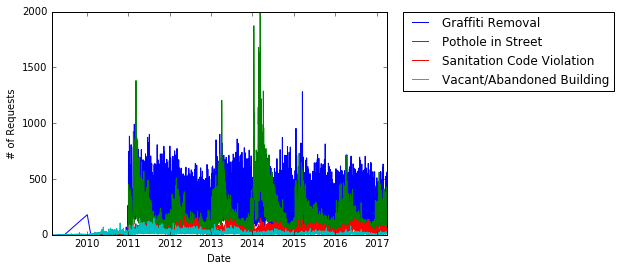

In [12]:
fig, ax = plt.subplots()

service_requests = ["Graffiti Removal", "Pothole in Street", 
                    "Sanitation Code Violation", "Vacant/Abandoned Building"]

for service in service_requests:

    serv_data = data[data["type of service request"] == service][["creation date", "type of service request"]]
    grouped_by = serv_data.groupby("creation date").count()

    ax.plot(grouped_by.index, grouped_by['type of service request'], label=service)

plt.xlabel("Date")
plt.ylabel("# of Requests")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [13]:
# count most and least often requesting zip code by service request 
for service in service_requests:

    serv_data = data[data["type of service request"] == service][["type of service request", "zip code"]]
    n_rows = len(serv_data)
    
    grouped_by = serv_data.groupby("zip code", as_index=False).count()
    grouped_by = grouped_by.sort_values('type of service request', ascending=False)
    
    grouped_by["pct"] = grouped_by["type of service request"].apply(lambda x: 100 * x / n_rows)
    grouped_by.columns = ["zip code", "count", "% of requests"]
    
    print("For service request: -- {} --, the 5 ZIP codes with the most requests are:\n{}\n".
          format(service, grouped_by.head(5)))

For service request: -- Graffiti Removal --, the 5 ZIP codes with the most requests are:
   zip code  count  % of requests
32    60632  94954      11.104861
8     60608  73968       8.650550
47    60647  66962       7.831199
18    60618  62354       7.292294
23    60623  51463       6.018593

For service request: -- Pothole in Street --, the 5 ZIP codes with the most requests are:
   zip code  count  % of requests
29    60629  18456       4.030838
28    60628  15620       3.411449
17    60617  15471       3.378907
18    60618  15026       3.281718
47    60647  14891       3.252233

For service request: -- Sanitation Code Violation --, the 5 ZIP codes with the most requests are:
   zip code  count  % of requests
20    60620   6010       5.059008
19    60619   5217       4.391488
27    60628   5202       4.378862
18    60618   4670       3.931043
17    60617   4527       3.810670

For service request: -- Vacant/Abandoned Building --, the 5 ZIP codes with the most requests are:
   zip cod

### Open Question: 

- How is the amount of requests influenced by population size in that zip code? I.e., which ZIP code population is more likely to call 311?


Data for:  Graffiti Removal


count    854844.000000
mean          4.416442
std          17.194354
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        2528.000000
Name: response time, dtype: float64

(0, 100)

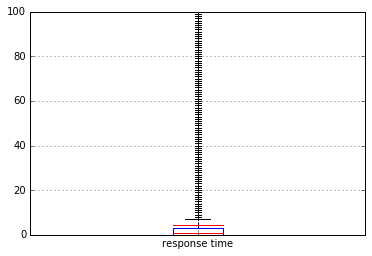


Data for:  Pothole in Street


count    454752.000000
mean         29.828623
std          60.595361
min           0.000000
25%           1.000000
50%           8.000000
75%          29.000000
max        1009.000000
Name: response time, dtype: float64

(0, 100)

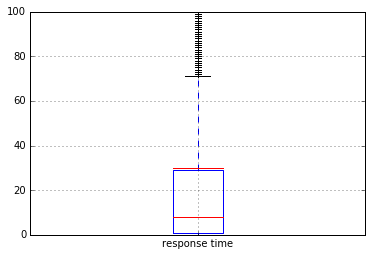


Data for:  Sanitation Code Violation


count    118475.000000
mean          8.599249
std          33.400740
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1643.000000
Name: response time, dtype: float64

(0, 100)

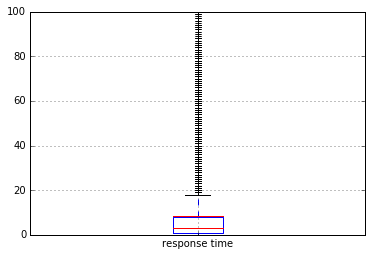

In [14]:
#How long does it take the city to respond to service requests?
data["response time"] = data["response time"].astype('timedelta64[D]')

#don't have completion date for Vacant/Abandoned Building
for service in service_requests[:3]:

    serv_data = data[data["type of service request"] == service][["type of service request", "response time"]]
    
    print("\nData for: ", service)
    serv_data["response time"].describe()
    
    serv_data.boxplot(column='response time', meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=True)
    plt.ylim([0,100])
    plt.show()

### Interesting Observations
- __Pothole in Street__ requests peak during/after winter months which makes sense. It looks like 2014 was an especially hard winter.
- While __Graffiti Removal__ does not have that strong of peaks, there still seem to be more requests in warmer months than in colder months of the year.
- Overall, the number of total requests decreased over time.
- The 2 zip codes, 60632 and 60636, are responsible for more than 10% of all requests for graffiti removals and vacant buildings, respectively.
- On average, potholes in street take the longest time to be fixed. Since the requests peak during/after winter, maybe the city needs to hire more companies specifically during that time in order to respond to the requests faster? Or is it not possible to fix potholes when the streets are wet/covered in snow?

----
# Problem 2: Data Augmentation and APIs

In [15]:
#Reading API key for CitySDK from textfile
with open("data/CitySDK_API_Key.txt","r") as file:
    api_key = file.read()

In [16]:
def get_census_attributes(zip_code):

    request_url = "http://citysdk.commerce.gov"

    request_obj = {
        'zip': zip_code,
        'state': 'IL',
        'level': 'track',
        'api': 'acs5',
        'year': 2010,
        'variables': ['income', 'population', 'age', 'median_house_construction_year', 
                      'education_bachelors', 'employment_unemployed']
    }
    try_counter = 0
    while try_counter < 4:
        try_counter += 1
        try:
            print("Making URL request")
            response = requests.post(request_url, auth=HTTPBasicAuth(api_key, None), json=request_obj, timeout=None)
            if response.status_code == 200:
                break
            elif try_counter == 3:
                #API was not returning results for select ZIPs;
                #setting values to 0 for now.
                return (0,0,0,0,0,0)
            
            #likely that we got 504 error; delaying next requests
            time.sleep(0.5)
        except:
            raise
    
    response = response.json()

    #avail variables can be found here:
    # https://github.com/uscensusbureau/citysdk/blob/master/src/resources/aliases.json
    
    #Median household income in the past 12 months (in 2013 inflation-adjusted dollars)
    income = response['features'][0]['properties']['B19013_001E']

    #Total population
    population = response['features'][0]['properties']['B01003_001E']

    #Median Age
    age = response['features'][0]['properties']['B01002_001E']

    #median_house_construction_year
    median_house_construction_year = response['features'][0]['properties']['B25035_001E']

    #number of persons age 25 and over who hold a Bachelor's degree
    education_bachelors = response['features'][0]['properties']['B15003_022E']

    #Number of unemployed, age 16 or older, in the civilian labor force
    unemployed = response['features'][0]['properties']['B23025_005E']
    
    return (income, population, age, median_house_construction_year, education_bachelors, unemployed)

In [17]:
census_file = "data/census.json"

if os.path.exists(census_file):
    with open(census_file) as json_file:    
        census_dict = json.load(json_file)
else:
    census_dict = {}
        
# using set of zip codes instead of lon & lat to 
# minimize amount of API requests
# to-do for future: 
#     - use lon & lat for higher accuracy
#     - OR download census data once

zip_codes = set(data['zip code'])
for zip_code in zip_codes:
    if zip_code != 'nan':
        if not zip_code in census_dict:
            print("Requesting data for zip: {}".format(zip_code))
            census_dict[zip_code] = get_census_attributes(zip_code)

In [18]:
with open(census_file, 'w') as outfile:
    json.dump(census_dict, outfile)

In [19]:
census_df = pd.DataFrame.from_dict(census_dict, orient='index').reset_index()
census_df.columns = ["zip code", "income", "population", "age", "median_house_construction_year", 
                     "education_bachelors", "unemployed"]

In [20]:
#Merging all three tables: data, community area from CHI open data, and census_df
community_area_data.rename(columns = {'community area number':'community area'}, inplace = True)
data = data.join(community_area_data.set_index('community area'), on="community area")
data = data.join(census_df.set_index("zip code"), on="zip code")

### What types of blocks (ZIP codes in this case) get “Vacant and Abandoned Buildings Reported”?

In [21]:
data["population"] = data["population"].astype(float)
data["education_bachelors"] = data["education_bachelors"].astype(float)
data["unemployed"] = data["unemployed"].astype(float)

data["bachelor_rate"] = data["education_bachelors"] / data["population"] * 100
data["unempl_rate"] = data["unemployed"] / data["population"] * 100

vacant_data = data[data["type of service request"] == "Vacant/Abandoned Building"]
vacant_data = vacant_data[["income", "population", "age", "median_house_construction_year", 
                           "bachelor_rate", "unempl_rate"]]

other_requests = data[data["type of service request"] != "Vacant/Abandoned Building"]

vacant_data = vacant_data.apply(pd.to_numeric, errors='ignore')

In [22]:
#General description of the ZIP codes that reported Vacant/Abandoned Building
vacant_data.describe()

,income,population,age,median_house_construction_year,bachelor_rate,unempl_rate
count,58317.000000,58317.000000,58317.000000,58317.000000,58313.000000,58313.000000
mean,36760.125778,1399.172660,33.754346,1945.047585,8.019548,8.729883
std,17598.717817,427.350675,9.205214,21.406672,8.290579,4.225457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27391.000000,1185.000000,25.900000,1939.000000,3.463649,5.679862
50%,33750.000000,1370.000000,31.400000,1939.000000,4.963504,9.404849
75%,38750.000000,1544.000000,37.600000,1940.000000,9.012346,11.285266
max,145250.000000,3233.000000,58.800000,2002.000000,53.863135,17.412141


In [23]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## How do the ZIPs with reported Vacant/Abandoned Buildings differ from 
## the ZIPs that reported other requests?
## Note: Since we are comparing ZIPs with each other, there can be 
## a significant overlap between the ZIPs that we are comparing.

#Does the income matter? 
print("Difference in Income:")
vacant_data.income.describe() - other_requests.income.astype(float).describe()

#Does unemployment rate matter?
print("\nDifference in Unemployment Rate:")
vacant_data.unempl_rate.describe() - other_requests.unempl_rate.describe()

Difference in Income:


count   -1370696.000
mean      -17823.170
std        -8085.317
min            0.000
25%        -6359.000
50%       -14676.000
75%       -36016.000
max            0.000
Name: income, dtype: float64


Difference in Unemployment Rate:


count   -1369815.000
mean           2.203
std            0.876
min            0.000
25%            1.478
50%            3.725
75%            1.880
max            0.000
Name: unempl_rate, dtype: float64

### Answer:
Zip codes that got Vacant and Abandoned Buildings reported have a lower income and a slightly higher unemployment rate.

### What types of blocks (ZIP codes in our case) get “Sanitation Code Complaints”?

In [24]:
sanitation_data = data[data["type of service request"] == "Sanitation Code Violation"]
sanitation_data = sanitation_data[["income", "population", "age", "median_house_construction_year", 
                           "bachelor_rate", "unempl_rate"]]

other_requests = data[data["type of service request"] != "Sanitation Code Violation"]

sanitation_data = sanitation_data.apply(pd.to_numeric, errors='ignore')

In [25]:
#General description of the ZIP codes that reported Sanitation Code Complaints
sanitation_data.describe()

,income,population,age,median_house_construction_year,bachelor_rate,unempl_rate
count,118705.000,118705.000,118705.000,118705.000,118700.000,118700.000
mean,50050.626,1467.160,34.354,1945.765,13.676,7.194
std,27517.005,521.885,8.380,19.298,12.656,3.797
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,31442.000,1121.000,28.300,1939.000,4.257,4.363
50%,41053.000,1370.000,33.500,1939.000,9.012,6.642
75%,69297.000,1739.000,37.600,1946.000,20.821,9.959
max,145250.000,3233.000,58.800,2002.000,53.863,17.412


In [26]:
#Does age of house construction matter?
print("Difference in Median House Construction Year:")
sanitation_data.median_house_construction_year.describe() - other_requests.median_house_construction_year.astype(float).describe()

#Does % of bachelor degree matter?
print("Difference in % of population with bachelor degree:")
sanitation_data.bachelor_rate.describe() - other_requests.bachelor_rate.describe()

Difference in Median House Construction Year:


count   -1249920.000
mean           1.735
std          -32.089
min            0.000
25%            0.000
50%            0.000
75%            0.000
max            0.000
Name: median_house_construction_year, dtype: float64

Difference in % of population with bachelor degree:


count   -1249041.000
mean          -1.498
std           -1.057
min            0.000
25%            0.000
50%           -0.282
75%           -3.466
max            0.000
Name: bachelor_rate, dtype: float64

__Answer__: 

We don't observe strong differences between the ZIP codes that request Sanitation Code complaints and ZIP codes that call 311 for other reasons when it comes to % of population with a bachelor degree or the median house construction year.

In [27]:
# Another approach: Is there a relationship between the relative 
# frequency with which service requests are made and population attributes? 

data["occur"] = 1
data_gb = data[["zip code", "type of service request", "occur"]]
gb = data_gb.groupby(["zip code", "type of service request"], as_index=False).count()

count_by_zip = data.groupby(["zip code"], as_index=False).count()[["zip code", "occur"]]
count_by_zip.columns = ["zip code", "total_occur"]

gb = gb.join(count_by_zip.set_index('zip code'), on="zip code")
gb = gb.join(census_df.set_index("zip code"), on="zip code")
gb = gb.apply(pd.to_numeric, errors='ignore')

gb["rel_occur"] = gb.occur / gb.total_occur * 100
gb["bachelor_rate"] = gb.education_bachelors / gb.population * 100
gb["unempl_rate"] = gb.unemployed / gb.population * 100

#not 100% accurate, because we would need to look at age of houses 
#at time of request, but this will need to do for now
gb["house_age_in_years"] = 2017 - gb["median_house_construction_year"]

#dropping ZIPs with population of 0
gb = gb[gb.population != 0]

In [28]:
for service in service_requests:
    serv_data = gb[gb["type of service request"] == service]
    
    print("\nCorrelation Matrix for service: {}".format(service))
    serv_data.drop(['occur', 'population','total_occur', 'median_house_construction_year', 
                    'education_bachelors', 'unemployed'], axis=1).corr()
    
    #For now, we fit a linear regression (OLS)
    result = sm.ols(formula="rel_occur ~ income + age + bachelor_rate + unempl_rate + house_age_in_years",
                    data=serv_data).fit()
    result.summary()


Correlation Matrix for service: Graffiti Removal


,income,age,rel_occur,bachelor_rate,unempl_rate,house_age_in_years
income,1.000,-0.022,0.252,0.544,-0.505,-0.320
age,-0.022,1.000,-0.231,0.174,0.096,-0.018
rel_occur,0.252,-0.231,1.000,0.355,-0.251,-0.008
bachelor_rate,0.544,0.174,0.355,1.000,-0.257,-0.306
unempl_rate,-0.505,0.096,-0.251,-0.257,1.000,0.052
house_age_in_years,-0.320,-0.018,-0.008,-0.306,0.052,1.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rel_occur   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     3.311
Date:                Wed, 05 Apr 2017   Prob (F-statistic):             0.0114
Time:                        00:50:20   Log-Likelihood:                -258.63
No. Observations:                  58   AIC:                             529.3
Df Residuals:                      52   BIC:                             541.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             58.3793     20.799      2.807      0.007        16.642   100.116
income             -2.729e-06      0.000     -0.020      0.984        -0.000     0.000
age                   -0.8795      0.380     -2.312      0.025        -1.643    -0.116
bachelor_rate          0.7480      0.273      2.739      0.008         0.200     1.296
unempl_rate           -0.8123      0.916     -0.886      0.380        -2.651     1.027
house_age_in_years     0.1373      0.153      0.900      0.372        -0.169     0.443
==============================================================================
Omnibus:                        0.656   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.720   Jarque-Bera (JB):                0.767
Skew:                           0.148   Prob(JB):                        0.682
Kurtosis:                       2.521   Cond. No.                     4.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Correlation Matrix for service: Pothole in Street


,income,age,rel_occur,bachelor_rate,unempl_rate,house_age_in_years
income,1.000,-0.022,0.012,0.544,-0.505,-0.320
age,-0.022,1.000,0.303,0.174,0.096,-0.018
rel_occur,0.012,0.303,1.000,-0.185,0.012,-0.098
bachelor_rate,0.544,0.174,-0.185,1.000,-0.257,-0.306
unempl_rate,-0.505,0.096,0.012,-0.257,1.000,0.052
house_age_in_years,-0.320,-0.018,-0.098,-0.306,0.052,1.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rel_occur   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2.685
Date:                Wed, 05 Apr 2017   Prob (F-statistic):             0.0312
Time:                        00:50:20   Log-Likelihood:                -242.27
No. Observations:                  58   AIC:                             496.5
Df Residuals:                      52   BIC:                             508.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             25.4503     15.688      1.622      0.111        -6.031    56.931
income                 0.0001      0.000      1.004      0.320        -0.000     0.000
age                    0.8477      0.287      2.955      0.005         0.272     1.423
bachelor_rate         -0.5375      0.206     -2.609      0.012        -0.951    -0.124
unempl_rate           -0.1543      0.691     -0.223      0.824        -1.541     1.233
house_age_in_years    -0.1358      0.115     -1.180      0.243        -0.367     0.095
==============================================================================
Omnibus:                        0.807   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.668   Jarque-Bera (JB):                0.746
Skew:                           0.264   Prob(JB):                        0.689
Kurtosis:                       2.830   Cond. No.                     4.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Correlation Matrix for service: Sanitation Code Violation


,income,age,rel_occur,bachelor_rate,unempl_rate,house_age_in_years
income,1.000,-0.022,-0.460,0.544,-0.505,-0.320
age,-0.022,1.000,0.140,0.174,0.096,-0.018
rel_occur,-0.460,0.140,1.000,-0.366,0.421,0.177
bachelor_rate,0.544,0.174,-0.366,1.000,-0.257,-0.306
unempl_rate,-0.505,0.096,0.421,-0.257,1.000,0.052
house_age_in_years,-0.320,-0.018,0.177,-0.306,0.052,1.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rel_occur   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     4.498
Date:                Wed, 05 Apr 2017   Prob (F-statistic):            0.00176
Time:                        00:50:20   Log-Likelihood:                -172.67
No. Observations:                  58   AIC:                             357.3
Df Residuals:                      52   BIC:                             369.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              6.3154      4.725      1.336      0.187        -3.167    15.798
income             -4.111e-05   3.12e-05     -1.318      0.193        -0.000  2.15e-05
age                    0.1071      0.086      1.240      0.221        -0.066     0.281
bachelor_rate         -0.0876      0.062     -1.412      0.164        -0.212     0.037
unempl_rate            0.3766      0.208      1.809      0.076        -0.041     0.794
house_age_in_years     0.0105      0.035      0.302      0.764        -0.059     0.080
==============================================================================
Omnibus:                        2.465   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.357
Skew:                           0.473   Prob(JB):                        0.308
Kurtosis:                       2.715   Cond. No.                     4.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Correlation Matrix for service: Vacant/Abandoned Building


,income,age,rel_occur,bachelor_rate,unempl_rate,house_age_in_years
income,1.000,-0.022,-0.523,0.544,-0.505,-0.320
age,-0.022,1.000,-0.089,0.174,0.096,-0.018
rel_occur,-0.523,-0.089,1.000,-0.453,0.491,0.134
bachelor_rate,0.544,0.174,-0.453,1.000,-0.257,-0.306
unempl_rate,-0.505,0.096,0.491,-0.257,1.000,0.052
house_age_in_years,-0.320,-0.018,0.134,-0.306,0.052,1.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rel_occur   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     6.752
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           6.45e-05
Time:                        00:50:20   Log-Likelihood:                -180.37
No. Observations:                  58   AIC:                             372.7
Df Residuals:                      52   BIC:                             385.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              9.8550      5.397      1.826      0.074        -0.974    20.684
income             -6.014e-05   3.56e-05     -1.688      0.097        -0.000  1.13e-05
age                   -0.0754      0.099     -0.764      0.449        -0.273     0.123
bachelor_rate         -0.1228      0.071     -1.734      0.089        -0.265     0.019
unempl_rate            0.5900      0.238      2.481      0.016         0.113     1.067
house_age_in_years    -0.0120      0.040     -0.303      0.763        -0.091     0.067
==============================================================================
Omnibus:                       14.218   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.392
Skew:                           1.024   Prob(JB):                     0.000276
Kurtosis:                       4.610   Cond. No.                     4.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Observations__:
- Graffiti Removal:
    - Two variables are significant: age and bachelor_rate.
    
    All else equal, the lower the age of the population, the higher the relative occurence of graffiti removal requests in that area. 
    
    AND
    
    All else equal, the higher the rate of individuals with bachelor degrees, the higher the relative occurence of graffiti removal requests in that area.  


- Pothole in Street:
    - Only one variable is significant: age.
    
    All else equal, the higher the age of the population, the higher the relative occurence of pothole in street requests in that area. -> Do older individuals care more about potholes in the street, so that they are more likely to focus on such requests? Or do ZIP codes with more potholes in the street have older population so that the population can't complain about e.g., graffities since there are just not as many graffities?


- Sanitation Code Violation:
    - No variable is significant.
    

- Vacant/Abandoned Building:
    - Only one variable is significant: unempl_rate.
    
    All else equal, the higher the unemployment rate, the higher the relative occurence of Vacant/Abandoned Building reports in that area.

__Caveats/Next Steps:__

- Education variable: It would make sense to look at the rates of individuals with _at least_ a bachelor's degree. Other educational variables could be included as well to gain a better understanding.

- We are comparing static values from census with a flow of values. This is not being reflected in this analysis. For example, it could be that the unemployment rate was only high in certain areas during the census, but that it sinced has decreased. Therefore, we must assume that the information obtained from the census remained the same over time and was a constant underlying of the 311-requests. This might not be the case. In order to actually determine the influence of certain variables on the service requests, we would ideally have panel data so that we can compare the amount of requests with the change in the variables' values.

- We are looking at relative occurence instead of total occurence. Thus, we are not saying that the absolute number of a respective 311 requests rises/falls corresponding to a change in above variables' values. Instead, it could also be the case that the relative importance of certain requests rises/falls as above variables change. 

### What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Sanitation Code Complaints”?

In [29]:
print("Data from ZIPs with Vacant and Abandoned Buildings Reported")
vacant_data.describe()
print("\nData from ZIPs with Sanitation Code Complaints")
sanitation_data.describe()
print("\nComparison: Sanitation - Vacant")
sanitation_data.describe() - vacant_data.describe()

Data from ZIPs with Vacant and Abandoned Buildings Reported


,income,population,age,median_house_construction_year,bachelor_rate,unempl_rate
count,58317.000,58317.000,58317.000,58317.000,58313.000,58313.000
mean,36760.126,1399.173,33.754,1945.048,8.020,8.730
std,17598.718,427.351,9.205,21.407,8.291,4.225
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,27391.000,1185.000,25.900,1939.000,3.464,5.680
50%,33750.000,1370.000,31.400,1939.000,4.964,9.405
75%,38750.000,1544.000,37.600,1940.000,9.012,11.285
max,145250.000,3233.000,58.800,2002.000,53.863,17.412



Data from ZIPs with Sanitation Code Complaints


,income,population,age,median_house_construction_year,bachelor_rate,unempl_rate
count,118705.000,118705.000,118705.000,118705.000,118700.000,118700.000
mean,50050.626,1467.160,34.354,1945.765,13.676,7.194
std,27517.005,521.885,8.380,19.298,12.656,3.797
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,31442.000,1121.000,28.300,1939.000,4.257,4.363
50%,41053.000,1370.000,33.500,1939.000,9.012,6.642
75%,69297.000,1739.000,37.600,1946.000,20.821,9.959
max,145250.000,3233.000,58.800,2002.000,53.863,17.412



Comparison: Sanitation - Vacant


,income,population,age,median_house_construction_year,bachelor_rate,unempl_rate
count,60388.000,60388.000,60388.000,60388.000,60387.000,60387.000
mean,13290.501,67.987,0.600,0.717,5.657,-1.536
std,9918.287,94.534,-0.825,-2.108,4.365,-0.428
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,4051.000,-64.000,2.400,0.000,0.793,-1.317
50%,7303.000,0.000,2.100,0.000,4.049,-2.763
75%,30547.000,195.000,0.000,6.000,11.809,-1.326
max,0.000,0.000,0.000,0.000,0.000,0.000


__Answer__:

On average, the ZIPs that have Sanitation complaints have a...
    - higher income
    - higher rate of individuals with a bachelor's degree
    - lower unemployment rate
   than the ZIPs that get “Vacant and Abandoned Buildings Reported”. 

In [40]:
gb[gb["zip code"] == "60620"][["zip code", "type of service request", "occur"]]

,zip code,type of service request,occur
80,60620,Graffiti Removal,1967
81,60620,Pothole in Street,14621
82,60620,Sanitation Code Violation,6010
83,60620,Vacant/Abandoned Building,3635


In [50]:
uptown_data = data[data["community area name"] == "Uptown"]
len(uptown_data[uptown_data["type of service request"] == "Graffiti Removal"])

11912

In [62]:
lawndale_data = data[(data["community area name"] == "North Lawndale") | (data["community area name"] == "South Lawndale")]
len(lawndale_data[lawndale_data["type of service request"] == "Graffiti Removal"])

62415